In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, \
                            accuracy_score,precision_score, recall_score, f1_score, \
                            confusion_matrix, ConfusionMatrixDisplay
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats

## Read in  Data:

In [2]:
df = pd.read_csv('./Data/cat_clean.csv')

In [3]:
df.describe()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
count,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000
mean,4.752602,1.539326,0.779670,4.619031,2.547753,0.847788,3.770190,4.088834,1.116397,1.096559,1.583743,2.025632,1.884480,1.789150,0.912395,1.070400
std,3.768478,0.498495,0.414506,1.576234,1.911887,0.359258,0.864699,0.878686,0.418163,0.368394,0.839547,0.996769,1.051775,0.997606,1.544499,0.384687
min,0.167100,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.789000,1.000000,1.000000,4.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,3.886300,2.000000,1.000000,4.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,6.778100,2.000000,1.000000,5.000000,5.000000,1.000000,4.000000,5.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1.000000
max,24.811000,2.000000,1.000000,8.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7.000000,3.000000


**Notes:**  
* I'm not sure if I will scale the age column for my distance-based classifiers. I feel like doing so will lose an aspect of interpretability if the goal here is to be able to predict if a cat you're going to adopt would be a wool-sucker or not. However, I do understand the importance of magnitiude in algorithms of that nature. 
* I am going to reocde `Behaviour_problem` as a binary of yes or no (compared to I don't know, no, yes dx'd by vet, yes dx'd by self). 
* I will try to do both multiclass and binary classification with wool sucking but I fear I won't have enough data to get much worth out of a multiclass classifier.
* I will try three flavors of logistic regression (binary, multiclass, ordinal). Two of random forest (binary, multiclass). And four KNN (binary, binary with age scaled, multiclass, multiclass with age scaled). 

# Preprocessing:

In [4]:
# Recode Behaviour_problem to binary
df['Behaviour_problem'].replace([1, 2, 3], [0, 1, 1], inplace=True)
df['Behaviour_problem'].value_counts()

0.0    5200
1.0     496
Name: Behaviour_problem, dtype: int64

In [5]:
# BINARY DATA SET
df_bin = df.copy()
# 0-2 = no sucking, 3-7 = sucking 
df_bin['ws_binary'] = df_bin['Wool_sucking'].replace({1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1})
df_bin.drop(columns='Wool_sucking', inplace=True)
df_bin.head()

# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
df_bin = pd.get_dummies(df_bin, columns=['Breed_group'], prefix='B')
df_bin[['ws_binary', 'B_MCO']].describe()

,ws_binary,B_MCO
count,5696.000000,5696.000000
mean,0.252282,0.055829
std,0.434361,0.229611
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [6]:
# Assign BINARY X and y
X_bin = df_bin.drop(columns='ws_binary')
y_bin = df_bin['ws_binary']

In [7]:
# MULTICLASS DATA SET 
df_multi = df.copy()

# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
df_multi = pd.get_dummies(df_multi, columns=['Breed_group'], prefix='B')
df_multi[['Wool_sucking', 'B_MCO']].describe()

,Wool_sucking,B_MCO
count,5696.000000,5696.000000
mean,0.912395,0.055829
std,1.544499,0.229611
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,7.000000,1.000000


In [8]:
# Assign MULTICLASS X and y
X_multi = df_multi.drop(columns='Wool_sucking')
y_multi = df_multi['Wool_sucking']

In [9]:
# I already know y has some serious class imablance for my wool-suckers, hence stratify
# binary train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin)

# multiclass train/test split 
X_trains, X_tests, y_trains, y_tests = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi)


# DO SCALING AFTER THIS STEP
'''# get age on scale of 0-5 which is about where everyone else
scaler = MinMaxScaler(feature_range=(0,5))
scaled_age = scaler.fit_transform(encoded_df['Age'].values.reshape(-1, 1))
encoded_df['scaled_age'] = scaled_age
encoded_scaled_df = encoded_df.drop(columns='Age')'''

"# get age on scale of 0-5 which is about where everyone else\nscaler = MinMaxScaler(feature_range=(0,5))\nscaled_age = scaler.fit_transform(encoded_df['Age'].values.reshape(-1, 1))\nencoded_df['scaled_age'] = scaled_age\nencoded_scaled_df = encoded_df.drop(columns='Age')"

# Training and testing :))))

In [10]:
# dataframe for scores amongst models

master_scores = pd.DataFrame(columns=['Model','Recall', 'F1', 'Precision', 'Accuracy'])

## Logistic Regression:
I expect binary to perform the best as I don't think we have enough data here to make a model with good predictive value. 

### Binary:

In [11]:
# BINARY - no scaling as logistic regression is not sensitive to magnitude 

# Instantiate model
log = LogisticRegression()

# Fit model
log.fit(X_train, y_train)

# Calculate Prediction, Predicted Probabilities, FPR, TPR
y_pred = log.predict(X_test)
y_pred_probs = log.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


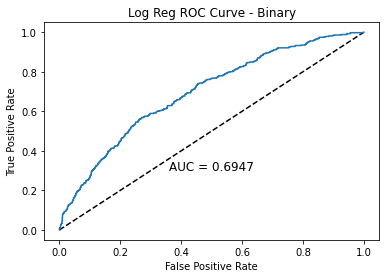

In [12]:
# Graph ROC with AUC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Binary")
plt.show();

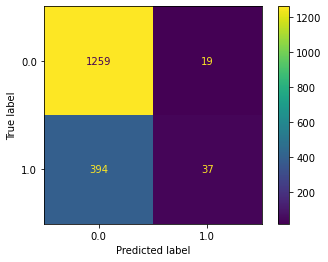

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()
plt.show();

In [14]:
# Evalution Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# add to master_scores
new_row = {
    'Model': 'Default Logistic Regression Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}
master_scores = master_scores.append(new_row, ignore_index=True)

# check out master_scores
master_scores.sort_values('Recall', ascending=False).head()

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3261644817.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
0,Default Logistic Regression Binary,0.09,0.15,0.66,0.76


**Binary Logistic Regression Interpretations:**  
The model does really well with true negatives, and pretty stinking awful at true positives. Of my 425 sucklers, it only correctly predicted 37 of them. This model performs okay in the broad scope but it truly does not live up to the intended goal of being able to accurately predict if a kitty I'm looking to adopt will wool-suck or not. Actually it pretty much just predicts that they all won't. I am going to make recall my main thing to watch out for for model comparison as that is where I assume my models will continue to struggle. 

### Multiclass:

In [15]:
# MULTICLASS 

# Instantiate model
logs = LogisticRegression(multi_class='multinomial')

# Fit model
logs.fit(X_trains, y_trains)

# Calculate Prediction
y_preds = logs.predict(X_tests)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


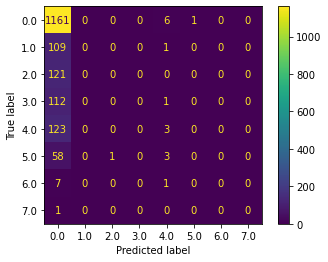

In [16]:
# Confusion Matrix 
cms = confusion_matrix(y_tests, y_preds, labels=logs.classes_)
disps = ConfusionMatrixDisplay(confusion_matrix=cms, display_labels=logs.classes_)
disps.plot()
plt.show();

As a reminder, 0 and 1 represent wool sucking behavior as never and 1-3 times in cat's lifetime. Past that is at least once/month. This did better than I thought it would, but that's really not saying much. It predicted a lot of 4's for when it did predict anything that wasn't "never."

In [17]:
# Metrics (accuracy, precidion, recall, f-1)
accuracy = accuracy_score(y_tests, y_preds)
precision = precision_score(y_tests, y_preds, average='macro') # I chose macro since we have less of the sucklers 
recall = recall_score(y_tests, y_preds, average='macro')       # and I want their accuracy to be meaningful
f1 = f1_score(y_tests, y_preds, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master_scores
new_row = {
    'Model': 'Default Logistic Regression Multiclass',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.6811000585137508
Precision: 0.11077127659574468
Recall: 0.12722704664057402
F1-score: 0.1068051629221842


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\670336538.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
0,Default Logistic Regression Binary,0.09,0.15,0.66,0.76


**Multiclass Logistic Regression Interpretations:** I expected it to do poorly. Technically it did better than binary on recall but all-in-all: it sucked. I'll still try with the ordinal logistic regression since my target feature is ordinal, but I do not expect much greatness.  

### Ordinal:

In [18]:
# ORDINAL
import statsmodels.api as sm
start_time = time.time()

# this algorithm prefers numpy arrays 
X_trains_o = X_trains.values
y_trains_o = y_trains.values

# Add constant to training
X_trains_o = sm.add_constant(X_trains_o)

# Instantiate model
ordinal_model = sm.MNLogit(y_trains_o, X_trains_o)

# Fit model
ordinal_results = ordinal_model.fit_regularized(method='l1', alpha=0.5)

end_time = time.time()
elapse_time = round((end_time - start_time), 2)
print(f"Elapsed Time {elapse_time} seconds.")

# Add constant to testing 
X_tests_o = X_tests.values
X_tests_o = sm.add_constant(X_tests_o)

# Calculate Predictions and Predicted Probabilities 
y_pred_probss = ordinal_results.predict(X_tests_o)
y_preds = np.argmax(y_pred_probss, axis=1)  # Convert predicted probabilities to class labels

Iteration limit reached    (Exit mode 9)
            Current function value: 1.0746165291655156
            Iterations: 1000
            Function evaluations: 1004
            Gradient evaluations: 1000
Elapsed Time 193.42 seconds.


C:\Users\gwent\anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 245 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\gwent\anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\gwent\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


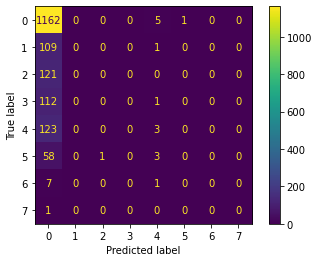

In [19]:
# Confusion Matrix
cms = confusion_matrix(y_tests, y_preds)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.show();

In [20]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_tests, y_preds)
precision = precision_score(y_tests, y_preds, average='macro')
recall = recall_score(y_tests, y_preds, average='macro')
f1 = f1_score(y_tests, y_preds, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Default Ordinal Logistic Regression',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.6816851960210649
Precision: 0.11258016201164459
Recall: 0.12733406718851925
F1-score: 0.10689506666000897


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\166955572.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
0,Default Logistic Regression Binary,0.09,0.15,0.66,0.76


**Ordinal Logistic Regression Interpretations:** Yeah... this has performed the worst (for our purposes, even though recall has improved compared to `log`) and taken the longest to run thus far. A big no thank you from me for this algorithm. 

### Parameter Tuning:
As expected, the binary performed the best. Next I will conduct a grid search with `log`.

In [21]:
# Grid Search for Binary Logistic Regression

# timing this process
start_time = time.time()


param_grid = {
    'C': [None, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': [None, 'l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'max_iter' : [100, 500, 1000]
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Hyperparameters:  {'C': 10.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.07457268114871188
Elapsed Time: 11.50 seconds


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
585 fits failed out of a total of 945.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
315 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 441, in _check_solver
    raise ValueError(
V

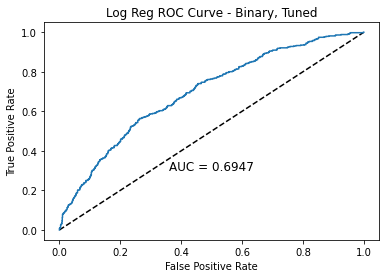

In [22]:
# re-plot w tuned parameters
log_tuned = grid_search.best_estimator_
log_tuned.fit(X_train, y_train)

y_pred_tuned = log_tuned.predict(X_test)
y_pred_probs_tuned = log_tuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_tuned)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs_tuned):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Binary, Tuned")
plt.show();

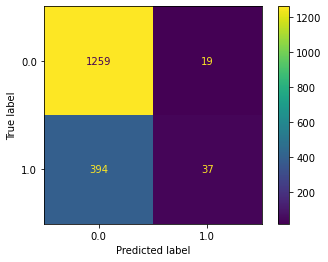

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned, labels=log_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_tuned.classes_)
disp.plot()
plt.show();

In [24]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_tuned)
precision = precision_score(y_test, y_pred_tuned)
recall = recall_score(y_test, y_pred_tuned)
f1 = f1_score(y_test, y_pred_tuned)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': '"Tuned" Log Reg Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.7583382094792276
Precision: 0.6607142857142857
Recall: 0.08584686774941995
F1-score: 0.1519507186858316


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3583767998.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
0,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
3,"""Tuned"" Log Reg Binary",0.09,0.15,0.66,0.76


For reference, untuned was:  
Accuracy: 0.7583382094792276  
Precision: 0.6607142857142857  
Recall: 0.08584686774941995  
F1-score: 0.1519507186858316  

They're exactly the same. Not ideal. Let's see if Random Forest has anything good to offer. 

## Random Forest:
This algorithm is also not sensitive to magnitude so I will not be scaling. I would think Random Forest would be my best bet at muticlass of the three, but I still don't have high hopes. 

### Binary:

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
# binary run

# instantiate the model 
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# predict and predicted probs 
y_pred = rf.predict(X_test)
y_pred_probs = rf.predict_proba(X_test)[:,1]

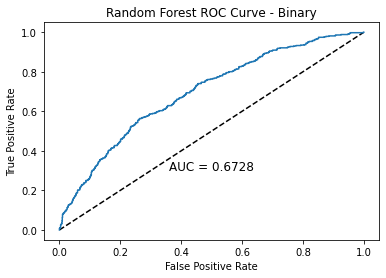

In [27]:
# ROC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve - Binary")
plt.show();

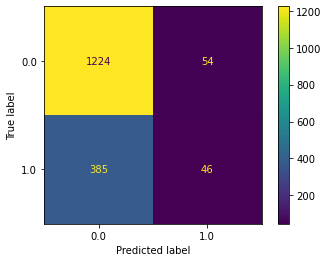

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show();

In [29]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Default Random Forest Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.743124634289058
Precision: 0.46
Recall: 0.10672853828306264
F1-score: 0.17325800376647832


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\4071157291.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
4,Default Random Forest Binary,0.11,0.17,0.46,0.74
0,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
3,"""Tuned"" Log Reg Binary",0.09,0.15,0.66,0.76


Running Best Scores (Log Binary Default:`log`):  
Accuracy: 0.7583382094792276  
Precision: 0.6607142857142857  
Recall: 0.08584686774941995  
F1-score: 0.1519507186858316  

**Binary RF Interpretations:** Fairly comparable to`log`. Recall is improved (at the sake of precision) but I'm more concerned about recall. A good chunk (~30) more of false positives, which is better than just automatically classifying everyone as a non-sucker. However, not a huge shift in true positives (+5)(yet a shift in the right direcction nonetheless). It'll be interesting to see how the multiclass performs. 

### Multiclass:

In [30]:
# multiclass run

# instantiate the model
rfs = RandomForestClassifier()

# fit the model
rfs.fit(X_trains, y_trains)

# predicted and predicted probs
y_preds = rfs.predict(X_tests)
y_pred_probss = rfs.predict_proba(X_tests)[:,1]

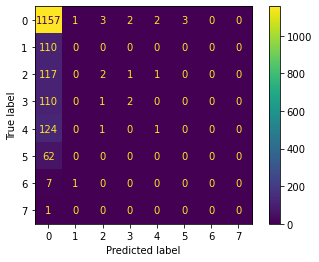

In [31]:
# Confusion Matrix
cms = confusion_matrix(y_tests, y_preds)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.show();

In [32]:
# Evaluation Metrics
accuracy = accuracy_score(y_tests, y_preds)
precision = precision_score(y_tests, y_preds, average='macro')
recall = recall_score(y_tests, y_preds, average='macro')
f1 = f1_score(y_tests, y_preds, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Default Random Forest Multiclass',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.6799297834991223
Precision: 0.20264260324983074
Recall: 0.12909334254767654
F1-score: 0.11134462626315195


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3533660504.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
5,Default Random Forest Multiclass,0.13,0.11,0.2,0.68
4,Default Random Forest Binary,0.11,0.17,0.46,0.74
0,Default Logistic Regression Binary,0.09,0.15,0.66,0.76


**RF Multiclass Interpretations:** I actually think this model isn't awful, but it's really not great. If you look at the confusion matrix, the few (20) that it tried to classify as suckers did pretty well. However, 9 of those 20 are misclassified 0s and 1s, which is not still not great. I'd say even with the improved recall, `rfs` is not beating `log`'s performance. But `rf` may still be in the running. 

### Parameter Tuning:
On the binary model, of course. 

In [33]:
start_time = time.time()

param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'random_state': [42],
    'max_features': ['auto', 'log2', None],
    'class_weight': [None, 'balanced']    
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 42}
Best Score:  0.2753608196640559
Elapsed Time: 195.77 seconds


In [34]:
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

# Display the top 5 performing models
top_5_models = sorted_results.head(5)
top_5_models

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.541765,0.003060,0.040457,0.001455,balanced,auto,10,300,42,"{'class_weight': 'balanced', 'max_features': '...",0.262376,0.263682,0.283582,0.283582,0.283582,0.275361,0.010077,1
44,0.552820,0.008402,0.045697,0.004447,balanced,log2,10,300,42,"{'class_weight': 'balanced', 'max_features': '...",0.262376,0.263682,0.283582,0.283582,0.283582,0.275361,0.010077,1
42,0.181807,0.006150,0.014826,0.000744,balanced,log2,10,100,42,"{'class_weight': 'balanced', 'max_features': '...",0.252475,0.263682,0.308458,0.268657,0.278607,0.274376,0.019006,3
33,0.184868,0.004347,0.015160,0.000399,balanced,auto,10,100,42,"{'class_weight': 'balanced', 'max_features': '...",0.252475,0.263682,0.308458,0.268657,0.278607,0.274376,0.019006,3
34,0.364829,0.005019,0.027482,0.000458,balanced,auto,10,200,42,"{'class_weight': 'balanced', 'max_features': '...",0.262376,0.273632,0.288557,0.258706,0.283582,0.273371,0.011584,5


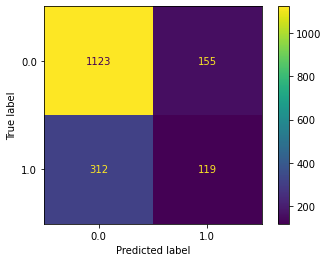

In [35]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show();

In [36]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Tuned Random Forest Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.7267407840842598
Precision: 0.4343065693430657
Recall: 0.27610208816705334
F1-score: 0.3375886524822695


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\701142798.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
6,Tuned Random Forest Binary,0.28,0.34,0.43,0.73
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
5,Default Random Forest Multiclass,0.13,0.11,0.2,0.68
4,Default Random Forest Binary,0.11,0.17,0.46,0.74


Running Best Scores (Log Binary Default:`log`):  
Accuracy: 0.7583382094792276  
Precision: 0.6607142857142857  
Recall: 0.08584686774941995  
F1-score: 0.1519507186858316   

I think this model is definitely better. Though I'm not loving it's lack of precision. The fact that weighting the classes made such a difference suggests that class imbalance is definitely playing a big part here, as expected. Per the suggestion of my mentor I would like to try class distribution balancing techniques.  
* Oversampling
    * SMOTE (Synthetic Minority Over-sampling Technique)
    * Random Over-Sampling
* Undersampling 
    * Random Under-Sampling

Out of curiosity, I want to see if using the same model as before but only changing class_weight='balance' does most of this significant improvement. 

Accuracy: 0.7419543592744295
Precision: 0.43243243243243246
Recall: 0.07424593967517401
F1-score: 0.12673267326732673


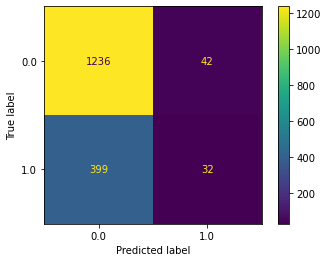

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3474442188.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
6,Tuned Random Forest Binary,0.28,0.34,0.43,0.73
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
5,Default Random Forest Multiclass,0.13,0.11,0.2,0.68
4,Default Random Forest Binary,0.11,0.17,0.46,0.74


In [37]:
rf_balanced = RandomForestClassifier(class_weight='balanced')
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_balanced)
precision = precision_score(y_test, y_pred_balanced)
recall = recall_score(y_test, y_pred_balanced)
f1 = f1_score(y_test, y_pred_balanced)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_balanced, labels=rf_balanced.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_balanced.classes_)
disp.plot()
plt.show();

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Random Forest Binary class_weight=balanced',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Intriguing! It does not. 

Accuracy: 0.7296664716208309
Precision: 0.4444444444444444
Recall: 0.2877030162412993
F1-score: 0.3492957746478873


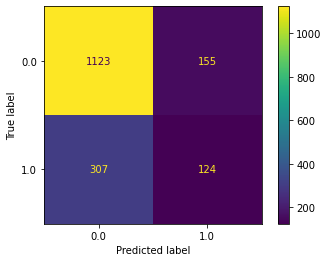

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\1215912268.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
8,Hand-Tuned Random Forest Binary,0.29,0.35,0.44,0.73
6,Tuned Random Forest Binary,0.28,0.34,0.43,0.73
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
5,Default Random Forest Multiclass,0.13,0.11,0.2,0.68


In [38]:
rf_3 = RandomForestClassifier(min_samples_split=10, class_weight='balanced', n_estimators=300)
rf_3.fit(X_train, y_train)
y_pred_3 = rf_3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_3)
precision = precision_score(y_test, y_pred_3)
recall = recall_score(y_test, y_pred_3)
f1 = f1_score(y_test, y_pred_3)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_3, labels=rf_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_3.classes_)
disp.plot()
plt.show();

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Hand-Tuned Random Forest Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

It seems these are the three hyperparamters that actually make the most difference for this context.

# Handling Class Imbalance

I'm going to implement a couple of class balancing methods to see if they make `rf_3` work any better. 

In [39]:
! pip install imbalanced-learn

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Accuracy: 0.7226448215330603
Precision: 0.4280936454849498
Recall: 0.29698375870069604
F1-score: 0.3506849315068493


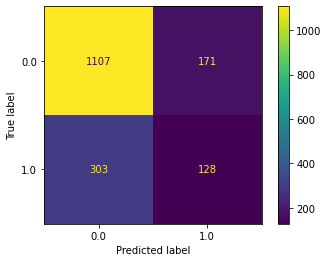

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\4223169319.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
9,Random Forest SMOTE Binary,0.3,0.35,0.43,0.72
8,Hand-Tuned Random Forest Binary,0.29,0.35,0.44,0.73
6,Tuned Random Forest Binary,0.28,0.34,0.43,0.73
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
2,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68


In [41]:
# random forest with SMOTE

rf_SMOTE = RandomForestClassifier(min_samples_split=10, n_estimators=300)
rf_SMOTE.fit(X_resampled, y_resampled)
y_pred_SMOTE = rf_SMOTE.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_SMOTE)
precision = precision_score(y_test, y_pred_SMOTE)
recall = recall_score(y_test, y_pred_SMOTE)
f1 = f1_score(y_test, y_pred_SMOTE)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_SMOTE, labels=rf_SMOTE.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_SMOTE.classes_)
disp.plot()
plt.show();

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Random Forest SMOTE Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Only slightly better than before (when class_weight arg removed).

In [42]:
from imblearn.over_sampling import RandomOverSampler

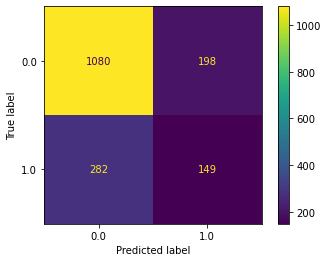

Accuracy: 0.719133996489175
Precision: 0.42939481268011526
Recall: 0.345707656612529
F1-score: 0.38303341902313626


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\2066630834.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
9,Random Forest SMOTE Binary,0.3,0.35,0.43,0.72
8,Hand-Tuned Random Forest Binary,0.29,0.35,0.44,0.73
6,Tuned Random Forest Binary,0.28,0.34,0.43,0.73
1,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68


In [43]:
# random forest with random oversampling

rf_ros = RandomForestClassifier(min_samples_split=10, n_estimators=300)
ros = RandomOverSampler()
X_rf_ros, y_rf_ros = ros.fit_resample(X_train, y_train)

rf_ros.fit(X_rf_ros, y_rf_ros)
y_pred = rf_ros.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_ros.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_ros.classes_)
disp.plot()
plt.show();

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Random Forest ROS Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

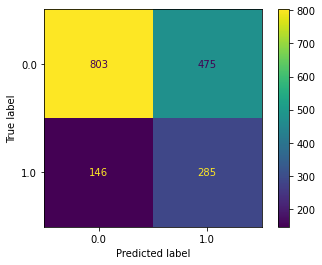

Accuracy: 0.63662960795787
Precision: 0.375
Recall: 0.6612529002320185
F1-score: 0.4785894206549119


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\2544129147.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
9,Random Forest SMOTE Binary,0.3,0.35,0.43,0.72
8,Hand-Tuned Random Forest Binary,0.29,0.35,0.44,0.73
6,Tuned Random Forest Binary,0.28,0.34,0.43,0.73


In [44]:
from imblearn.under_sampling import RandomUnderSampler

# random forest with undersampling

rf_rus = RandomForestClassifier(min_samples_split=10, n_estimators=300)
rus = RandomUnderSampler()
X_rf_rus, y_rf_rus = rus.fit_resample(X_train, y_train)

rf_rus.fit(X_rf_rus, y_rf_rus)
y_pred = rf_rus.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_rus.classes_)
disp.plot()
plt.show();

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Random Forest RUS Binary',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Much better than before! A new winner so far. 

Accuracy: 0.7366881217086015
Precision: 0.4666666666666667
Recall: 0.308584686774942
F1-score: 0.3715083798882682


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


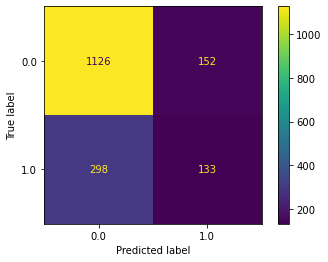

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\978783858.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74
9,Random Forest SMOTE Binary,0.3,0.35,0.43,0.72
8,Hand-Tuned Random Forest Binary,0.29,0.35,0.44,0.73


In [45]:
# log reg with SMOTE 
log_SMOTE = LogisticRegression()
log_SMOTE.fit(X_resampled, y_resampled)
y_pred_SMOTE = log_SMOTE.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_SMOTE)
precision = precision_score(y_test, y_pred_SMOTE)
recall = recall_score(y_test, y_pred_SMOTE)
f1 = f1_score(y_test, y_pred_SMOTE)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_SMOTE, labels=log_SMOTE.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_SMOTE.classes_)
disp.plot()
plt.show();

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Log Reg Binary SMOTE',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

It does tremendously improve the default `log` model as well.

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6319485078993563
Precision: 0.3700787401574803
Recall: 0.654292343387471
F1-score: 0.47275775356244765


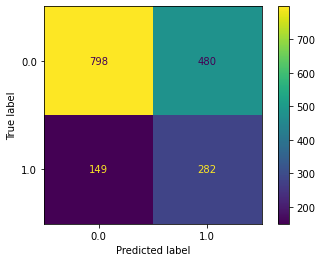

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3738453425.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74
9,Random Forest SMOTE Binary,0.3,0.35,0.43,0.72


In [46]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)

log_ros = LogisticRegression()
log_ros.fit(X_ros, y_ros)
y_pred_ros = log_ros.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_ros)
precision = precision_score(y_test, y_pred_ros)
recall = recall_score(y_test, y_pred_ros)
f1 = f1_score(y_test, y_pred_ros)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_ros, labels=log_ros.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_ros.classes_)
disp.plot()
plt.show();

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Log Reg Binary ROS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6220011702750147
Precision: 0.36129032258064514
Recall: 0.6496519721577726
F1-score: 0.46434494195688225


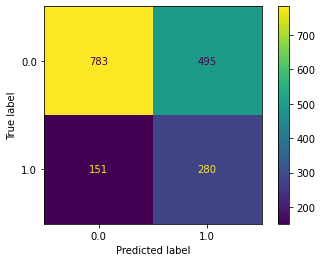

C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\28435924.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74


In [47]:
rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X_train, y_train)

log_rus = LogisticRegression()

log_rus.fit(X_rus, y_rus)

y_pred_rus = log_rus.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
precision = precision_score(y_test, y_pred_rus)
recall = recall_score(y_test, y_pred_rus)
f1 = f1_score(y_test, y_pred_rus)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_rus, labels=log_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_rus.classes_)
disp.plot()
plt.show();

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Log Reg Binary RUS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

For our purposes it seems like randomly undersampling the majority class is the most impactful. One final moment of curiosity, since it is now doing a lot of false-positives, I would like to add more granularity back into the mix and try it on a multiclass problem. 

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


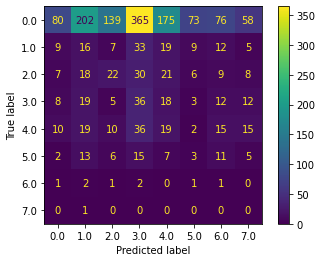

Accuracy: 0.10181392627267408
Precision: 0.1323607427055703
Recall: 0.033164765857324925
F1-score: 0.045255245850297526


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3439715850.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74


In [48]:
# resample using RUS on multiclass train set
russ = RandomUnderSampler()
X_russ, y_russ = russ.fit_resample(X_trains, y_trains)

# Instantiate model
logs_rus = LogisticRegression(multi_class='multinomial')

# Fit model
logs_rus.fit(X_russ, y_russ)

# Calculate Prediction
y_preds_russ = logs_rus.predict(X_tests)

cm = confusion_matrix(y_tests, y_preds_russ, labels=logs_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logs_rus.classes_)
disp.plot()
plt.show();

accuracy = accuracy_score(y_test, y_preds_russ)
precision = precision_score(y_test, y_preds_russ, average='macro')
recall = recall_score(y_test, y_preds_russ, average='macro')
f1 = f1_score(y_test, y_preds_russ, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Log Reg Multiclass RUS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Still not great, but! It's at least trying to predict sucklers now. However, it seems to be just guessing all over the place, except for 1 and 6, which it almost never guesses relative to the others. 

## KNN:
KNN is a distance-based algorithm, so I would assume scaling would increase performance. I still don't think I have enough data for multiclass prediction.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

### Binary

In [50]:
# KNN - BINARY

# instantiate model
knn = KNeighborsClassifier()

# I'm not sure what a good value for k would be, so let's start off with parameter tuning this time 
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')

# Fit it
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_probs = best_model.predict_proba(X_test)[:,1]

Best Parameters: {'n_neighbors': 3}


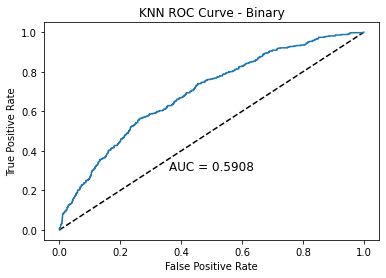

In [51]:
# ROC 
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve - Binary")
plt.show();

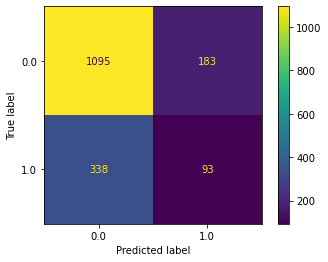

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()
plt.show();

In [53]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Binary KNN k=3',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.695143358689292
Precision: 0.33695652173913043
Recall: 0.21577726218097448
F1-score: 0.26308345120226306


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\962982189.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74


Right out of the box, KNN isn't doing too shabby!
For reference the highest scores so far have been:  
`log_rus` (Binary Logistic Regression - Randomly Undersampled)  
* Accuracy: 0.6383850204798127  
* Precision: 0.3748326639892905  
* Recall: 0.6496519721577726  
* F1-score: 0.47538200339558573  

`rf_rus` (Random Forest - Randomly Undersampled - `n_estimators=300, n_min_samples=10, class_weight='balanced'`)  
* Accuracy: 0.7302516091281451  
* Precision: 0.44485294117647056  
* Recall: 0.28074245939675174  
* F1-score: 0.3442389758179232  

### Binary KNN - Scaled

In [54]:
# scale data
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
# instantiate model
knn_scaled = KNeighborsClassifier()

# instantiate grid search
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_scaled, param_grid, cv=5, scoring='recall')

# Fit it
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_scaled = grid_search.best_estimator_
y_pred = best_scaled.predict(X_test_scaled)
y_pred_probs = best_scaled.predict_proba(X_test_scaled)[:,1]

Best Parameters: {'n_neighbors': 3}


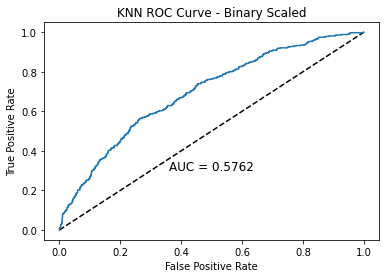

In [56]:
# ROC 
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve - Binary Scaled")
plt.show();

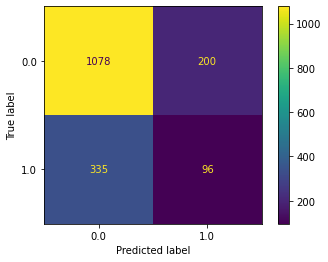

In [57]:
# Confusion Matrix
cm_scaled = confusion_matrix(y_test, y_pred, labels=best_scaled.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_scaled, display_labels=best_scaled.classes_)
disp.plot()
plt.show();

In [58]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Binary KNN k=3 All Scaled',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.6869514335868929
Precision: 0.32432432432432434
Recall: 0.22273781902552203
F1-score: 0.2640990371389271


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\1737531318.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74


### Scaling just the age column:

In [59]:
X_age_scaled = X_train.copy()
X_age_scaled_test = X_test.copy()

scaler_age = MinMaxScaler(feature_range=(0,5))
scaler_age.fit(X_age_scaled['Age'].values.reshape(-1,1))

X_age_scaled['Age'] = scaler_age.transform(X_age_scaled['Age'].values.reshape(-1, 1))
X_age_scaled_test['Age'] = scaler_age.transform(X_age_scaled_test['Age'].values.reshape(-1,1))

In [60]:
X_age_scaled.head()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,...,B_MCO,B_NFO,B_ORI,B_PER,B_RAG,B_RUS,B_SBI,B_SIB,B_TUV,B_other
4785,2.261249,2,1,3,0,1,3,5,1,1,...,0,0,0,0,0,0,0,0,0,0
2448,1.655927,2,1,2,5,0,3,3,1,2,...,0,0,0,0,0,0,0,0,0,0
4249,0.740406,1,1,4,3,1,3,5,1,1,...,0,0,0,0,0,0,0,0,0,0
1143,0.550319,1,1,4,1,1,5,5,1,1,...,0,0,0,0,0,0,0,0,0,0
4514,0.485820,2,1,7,0,1,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# instantiate model
knn_scaled = KNeighborsClassifier()

# instantiate grid search
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_scaled, param_grid, cv=5, scoring='recall')

# Fit it
grid_search.fit(X_age_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_scaled = grid_search.best_estimator_
y_pred = best_scaled.predict(X_age_scaled_test)
y_pred_probs = best_scaled.predict_proba(X_age_scaled_test)[:,1]

Best Parameters: {'n_neighbors': 3}


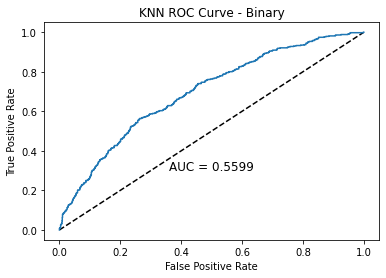

In [62]:
# ROC 
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve - Binary")
plt.show();

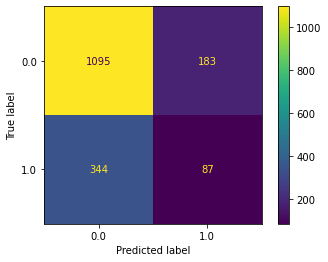

In [63]:
# Confusion Matrix
cm_scaled = confusion_matrix(y_test, y_pred, labels=best_scaled.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_scaled, display_labels=best_scaled.classes_)
disp.plot()
plt.show();

In [64]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Binary KNN k=3 Age Scaled',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.6916325336454067
Precision: 0.32222222222222224
Recall: 0.20185614849187936
F1-score: 0.24821683309557774


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3364006124.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74


I don't think we will be scaling anything in the data as it seems to make everything not work well. I am surprised by this as you would think being a distance-based algorithm would make KNN necessitate scaling, but alas. 

### Multiclass

In [65]:
# multiclass KNN 

knn_m = KNeighborsClassifier()

param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_m, param_grid, cv=5, scoring='recall')
grid_search.fit(X_trains, y_trains)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score: ", best_score)

best_multi_knn = grid_search.best_estimator_
y_pred = best_multi_knn.predict(X_tests)
y_pred_probs = best_multi_knn.predict_proba(X_tests)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1901, in recal

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1544, in precision_recall_fscore_support
  

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1901, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1544, in precision_recall_fscore_support
  

Best Parameters: {'n_neighbors': 3}
Best Score:  nan


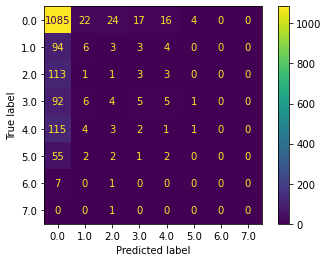

In [66]:
# Confusion Matrix
cm = confusion_matrix(y_tests, y_pred, labels=best_multi_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_multi_knn.classes_)
disp.plot()
plt.show();

In [67]:
# Evaluation Metrics
accuracy = accuracy_score(y_tests, y_pred)
precision = precision_score(y_tests, y_pred, average='macro')
recall = recall_score(y_tests, y_pred, average='macro')
f1 = f1_score(y_tests, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Multiclass KNN k=3',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Accuracy: 0.6424809830310123
Precision: 0.1325747675908031
Recall: 0.13049157113336035
F1-score: 0.12116457000203877


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\1481432575.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74


As to be expected! Multiclass is still not doing so hot with this small of a set. 

## KNN - binary - unscaled - with RUS and ROS

Best Parameters: {'n_neighbors': 3}


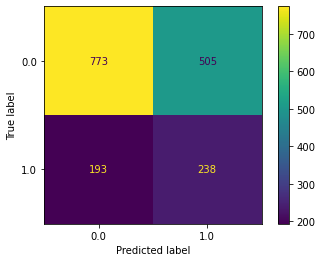

Accuracy: 0.5915740198946753
Precision: 0.3203230148048452
Recall: 0.5522041763341067
F1-score: 0.4054514480408859


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\3864908558.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
20,Binary KNN k=3 RUS,0.55,0.41,0.32,0.59
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72


In [68]:
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

knn_rus = KNeighborsClassifier()

gridsearch = GridSearchCV(knn_rus, param_grid = {'n_neighbors':[3, 5, 7, 9]}, cv=5, scoring='recall')
gridsearch.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

best_bin_rs = gridsearch.best_estimator_
y_pred = best_bin_rs.predict(X_test)
y_pred_probs = best_bin_rs.predict_proba(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_bin_rs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_bin_rs.classes_)
disp.plot()
plt.show();

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Binary KNN k=3 RUS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

Best Parameters: {'n_neighbors': 3}


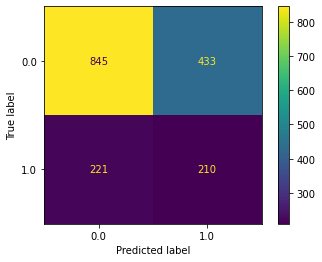

Accuracy: 0.6173200702165009
Precision: 0.3265940902021773
Recall: 0.4872389791183295
F1-score: 0.3910614525139665


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\2171986282.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
20,Binary KNN k=3 RUS,0.55,0.41,0.32,0.59
21,Binary KNN k=3 ROS,0.49,0.39,0.33,0.62


In [69]:
ros = RandomOverSampler()

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

knn_ros = KNeighborsClassifier()

gridsearch = GridSearchCV(knn_ros, param_grid = {'n_neighbors':[3, 5, 7, 9]}, cv=5, scoring='recall')
gridsearch.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

best_bin_rs = gridsearch.best_estimator_
y_pred = best_bin_rs.predict(X_test)
y_pred_probs = best_bin_rs.predict_proba(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_bin_rs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_bin_rs.classes_)
disp.plot()
plt.show();

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': 'Binary KNN k=3 ROS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

For reference the highest scores so far have been:  
`log_rus` (Binary Logistic Regression - Randomly Undersampled)  
* Accuracy: 0.6383850204798127  
* Precision: 0.3748326639892905  
* Recall: 0.6496519721577726  
* F1-score: 0.47538200339558573  

`rf_3` (Binary Random Forest - `n_estimators=300, n_min_samples=10, class_weight='balanced'`)  
* Accuracy: 0.7302516091281451  
* Precision: 0.44485294117647056  
* Recall: 0.28074245939675174  
* F1-score: 0.3442389758179232  

`knn` (binary K Nearest Neighbors - `n_neighbors=3` - unscaled) 
* Accuracy: 0.695143358689292
* Precision: 0.33695652173913043
* Recall: 0.21577726218097448
* F1-score: 0.26308345120226306

It's not awful but it's not great. The other three are certainly better. 

# Optimizing `log_rus`

`log_rus` has performed the best so far. I want to do a final parameter tuning for it and see if we can get rid of some of those pesky false positives. 

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Parameters:  {'C': 10.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.07457268114871188


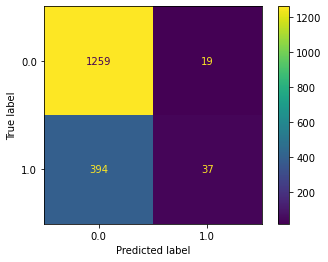

Accuracy: 0.7583382094792276
Precision: 0.6607142857142857
Recall: 0.08584686774941995
F1-score: 0.1519507186858316


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\1292268955.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
20,Binary KNN k=3 RUS,0.55,0.41,0.32,0.59
21,Binary KNN k=3 ROS,0.49,0.39,0.33,0.62


In [70]:
log_rus = LogisticRegression()

log_rus.fit(X_rus, y_rus)

param_grid = {
    'C': [None, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': [None, 'l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'max_iter' : [100, 500, 1000]
}

grid_search = GridSearchCV(log_rus, param_grid=param_grid, scoring='recall', cv=5)

# Fit the GridSearchCV to your data
grid_search.fit(X_train, y_train)

# Print the best parameter combination and the corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

best_log = grid_search.best_estimator_

y_pred = best_log.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_log.classes_)
disp.plot()
plt.show();

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': '"Tuned" Binary LogReg RUS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

In [71]:
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

# Display the top 5 performing models
top_5_models = sorted_results.head(5)
top_5_models

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
188,0.025205,0.007421,0.006245,0.007649,100.0,1000,l2,newton-cg,"{'C': 100.0, 'max_iter': 1000, 'penalty': 'l2'...",0.054455,0.049751,0.084577,0.074627,0.109453,0.074573,0.021622,1
161,0.028118,0.006248,0.003124,0.006248,10.0,1000,l2,newton-cg,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l2',...",0.054455,0.049751,0.084577,0.074627,0.109453,0.074573,0.021622,1
139,0.104118,0.015762,0.001200,0.002400,10.0,100,l1,liblinear,"{'C': 10.0, 'max_iter': 100, 'penalty': 'l1', ...",0.054455,0.049751,0.084577,0.074627,0.109453,0.074573,0.021622,1
141,0.016338,0.001432,0.003122,0.006244,10.0,100,l2,lbfgs,"{'C': 10.0, 'max_iter': 100, 'penalty': 'l2', ...",0.054455,0.049751,0.084577,0.074627,0.109453,0.074573,0.021622,1
142,0.012443,0.007781,0.003709,0.006049,10.0,100,l2,liblinear,"{'C': 10.0, 'max_iter': 100, 'penalty': 'l2', ...",0.054455,0.049751,0.084577,0.074627,0.109453,0.074573,0.021622,1


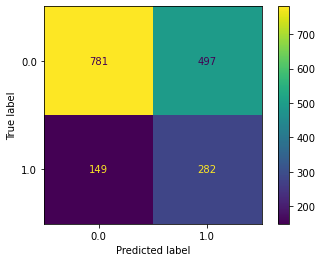

              precision    recall  f1-score   support

         0.0       0.84      0.61      0.71      1278
         1.0       0.36      0.65      0.47       431

    accuracy                           0.62      1709
   macro avg       0.60      0.63      0.59      1709
weighted avg       0.72      0.62      0.65      1709

Accuracy: 0.6220011702750147
Precision: 0.362002567394095
Recall: 0.654292343387471
F1-score: 0.46611570247933887


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\1775703098.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
23,"""Hand-Tuned"" Binary LogReg RUS",0.65,0.47,0.36,0.62
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
20,Binary KNN k=3 RUS,0.55,0.41,0.32,0.59


In [72]:
from sklearn.metrics import classification_report

log_opt = LogisticRegression(C=100, max_iter=250)

log_opt.fit(X_rus, y_rus)

y_pred_opt = log_opt.predict(X_test)
y_probs = log_opt.predict_proba(X_test)[:,1]

# confusion matrix
cm = confusion_matrix(y_test, y_pred_opt, labels=log_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_opt.classes_)
disp.plot()
plt.show();

# Generate the classification report
report = classification_report(y_test, y_pred_opt)
print(report)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': '"Hand-Tuned" Binary LogReg RUS',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

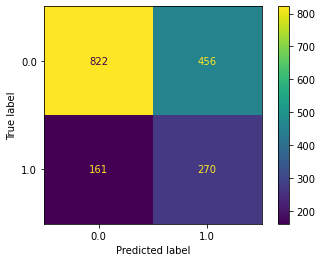

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.73      1278
         1.0       0.37      0.63      0.47       431

    accuracy                           0.64      1709
   macro avg       0.60      0.63      0.60      1709
weighted avg       0.72      0.64      0.66      1709

Accuracy: 0.6220011702750147
Precision: 0.362002567394095
Recall: 0.654292343387471
F1-score: 0.46611570247933887


C:\Users\gwent\AppData\Local\Temp\ipykernel_13684\1172442381.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_scores = master_scores.append(new_row, ignore_index=True)


,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
24,"""Tuned"" Binary LogReg RUS Threshold Adjusted",0.65,0.47,0.36,0.62
23,"""Hand-Tuned"" Binary LogReg RUS",0.65,0.47,0.36,0.62
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63


In [73]:
# adjusting the threshold to maybe describe fpr
y_pred_adjusted = np.where(y_probs >=0.52, 1, 0)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted, labels=log_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_opt.classes_)
disp.plot()
plt.show();

# Generate the classification report
report = classification_report(y_test, y_pred_adjusted)
print(report)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# add to master !!!!! UPDATE MODEL !!!!!
new_row = {
    'Model': '"Tuned" Binary LogReg RUS Threshold Adjusted',
    'Recall': round(recall,2), 
    'F1': round(f1, 2), 
    'Precision': round(precision, 2), 
    'Accuracy': round(accuracy, 2)}

# check out master_scores
master_scores = master_scores.append(new_row, ignore_index=True)
master_scores.sort_values('Recall', ascending=False).head()

It didn't really help to adjust the threshold for a positive. 

### Question: When you reassociate the original class pre-binarization, which ones is it getting wrong most often?

Accuracy: 0.6249268578115857
Precision: 0.36363636363636365
Recall: 0.6496519721577726
F1-score: 0.466278101582015


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


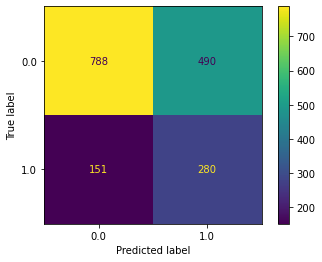

In [74]:
X, y = df_bin.drop(columns='ws_binary'), df_bin['ws_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X_train, y_train)

log_rus = LogisticRegression()

log_rus.fit(X_rus, y_rus)

y_pred_rus = log_rus.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
precision = precision_score(y_test, y_pred_rus)
recall = recall_score(y_test, y_pred_rus)
f1 = f1_score(y_test, y_pred_rus)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_rus, labels=log_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_rus.classes_)
disp.plot()
plt.show();

In [75]:
#log_rus


# reassociate original variable
#pred_test = pd.DataFrame(zip(y_pred, y_test ))

#final = 


# Recap:

Only the binary classifiers did a good job! We tried Logistic Regression, a Random Forest, and KNN.

We will be carrying on with the following model: 
`log_rus` (LogisticRegression with default parameters trained on randomly undersampled data.)  

It has the highest recall, which is important because initial modelling suggested that would be my dataset's weakness. 

In [76]:
master_scores.sort_values('Recall', ascending=False)

,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.66,0.48,0.38,0.64
24,"""Tuned"" Binary LogReg RUS Threshold Adjusted",0.65,0.47,0.36,0.62
23,"""Hand-Tuned"" Binary LogReg RUS",0.65,0.47,0.36,0.62
14,Log Reg Binary RUS,0.65,0.46,0.36,0.62
13,Log Reg Binary ROS,0.65,0.47,0.37,0.63
20,Binary KNN k=3 RUS,0.55,0.41,0.32,0.59
21,Binary KNN k=3 ROS,0.49,0.39,0.33,0.62
10,Random Forest ROS Binary,0.35,0.38,0.43,0.72
12,Log Reg Binary SMOTE,0.31,0.37,0.47,0.74
9,Random Forest SMOTE Binary,0.3,0.35,0.43,0.72
